<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/Clustering_labo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio de data mining
Vamos a usar el dataset de http://archive.ics.uci.edu/ml/datasets/wiki4HE, que son dos encuentas de uso de Wikipedia en distintas universidades

In [6]:
# Gráficos
import matplotlib.pyplot as plt
#import matplotlib as mpl
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16

#from IPython.display import Audio, Markdown, Image
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Link con el Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
df = pd.read_csv('/content/wiki4HE.csv',sep=';')
df.head()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,PU1,PU2,PU3,PEU1,PEU2,PEU3,ENJ1,ENJ2,Qu1,Qu2,Qu3,Qu4,Qu5,Vis1,Vis2,Vis3,Im1,Im2,Im3,SA1,SA2,SA3,Use1,Use2,Use3,Use4,Use5,Pf1,Pf2,Pf3,JR1,JR2,BI1,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
0,40,0,2,1,14,1,2,?,?,0,4,4,3,5,5,3,4,4,3,3,2,2,3,3,3,1,2,4,2,4,4,4,3,1,1,2,4,1,1,3,4,1,2,3,5,5,5,5,4,4,4,1,2
1,42,0,5,1,18,1,2,?,?,0,2,3,3,4,4,3,3,4,4,4,3,3,2,3,3,1,1,2,1,4,4,4,2,2,1,1,2,1,1,1,4,3,2,2,4,4,3,4,2,2,4,2,4
2,37,0,4,1,13,1,3,?,?,0,2,2,2,4,4,3,3,3,2,2,2,5,3,2,3,2,2,4,3,4,2,4,1,1,1,1,1,3,3,3,4,3,1,1,5,3,5,5,2,2,2,1,3
3,40,0,4,0,13,1,3,?,?,0,3,3,4,3,3,3,4,3,3,4,3,3,3,3,4,3,2,2,3,5,5,5,3,3,3,3,3,4,4,4,5,4,3,3,3,4,4,3,4,4,3,3,4
4,51,0,6,0,8,1,3,?,?,1,4,3,5,5,4,3,4,4,4,5,4,3,4,4,4,4,3,2,3,5,5,5,3,3,5,5,5,5,5,5,3,3,5,5,5,5,4,4,5,5,5,4,4


In [9]:
df.shape

(913, 53)

In [10]:
df.columns

Index(['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY',
       'UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS', 'USERWIKI', 'PU1',
       'PU2', 'PU3', 'PEU1', 'PEU2', 'PEU3', 'ENJ1', 'ENJ2', 'Qu1', 'Qu2',
       'Qu3', 'Qu4', 'Qu5', 'Vis1', 'Vis2', 'Vis3', 'Im1', 'Im2', 'Im3', 'SA1',
       'SA2', 'SA3', 'Use1', 'Use2', 'Use3', 'Use4', 'Use5', 'Pf1', 'Pf2',
       'Pf3', 'JR1', 'JR2', 'BI1', 'BI2', 'Inc1', 'Inc2', 'Inc3', 'Inc4',
       'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5'],
      dtype='object')

In [11]:
df.describe()

,AGE,GENDER,PhD,UNIVERSITY
count,913.000000,913.000000,913.000000,913.000000
mean,42.246440,0.424973,0.464403,1.123768
std,8.058418,0.494610,0.499005,0.329497
min,23.000000,0.000000,0.000000,1.000000
25%,36.000000,0.000000,0.000000,1.000000
50%,42.000000,0.000000,0.000000,1.000000
75%,47.000000,1.000000,1.000000,1.000000
max,69.000000,1.000000,1.000000,2.000000


# Limpieza y preparación de los datos

## Datos faltantes
Primero revisamos como están codificados los datos faltantes, y encontramos que se uso el signo de pregunta (podrían estar codificados de distintas formas).

Podemos primero explorar cuántos datos faltantes hay por columna. Recuerden que hay ~900 registros.

In [14]:
df.apply(lambda x: np.sum(x=='?'))

AGE                 0
GENDER              0
DOMAIN              2
PhD                 0
YEARSEXP           23
UNIVERSITY          0
UOC_POSITION      113
OTHER_POSITION    261
OTHERSTATUS       540
USERWIKI            4
PU1                 7
PU2                11
PU3                 5
PEU1                4
PEU2               14
PEU3               97
ENJ1                7
ENJ2               17
Qu1                 7
Qu2                10
Qu3                15
Qu4                22
Qu5                29
Vis1               72
Vis2              117
Vis3                8
Im1                22
Im2                20
Im3                57
SA1                11
SA2                12
SA3                11
Use1               14
Use2               17
Use3                9
Use4               23
Use5               15
Pf1                11
Pf2                 6
Pf3                14
JR1                27
JR2                53
BI1                32
BI2                43
Inc1               35
Inc2      

Luego, podemos explorar si todos los datos están en algunas filas en particular. Recuerden que hay ~50 columnas.

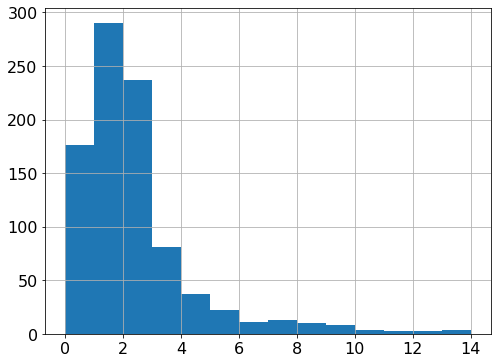

In [13]:
df.apply(lambda x: np.sum(x=='?'),axis=1).hist(bins=range(0,15))

Finalmente, podemos ver cuántos datos hay sin ningún dato faltante.

In [15]:
print('Hay %d registros sin datos faltantes.'%sum(df.apply(lambda x: np.sum(x=='?'),axis=1)==0))

Hay 176 registros sin datos faltantes.


Hay pocas variables que concentran muchos valores faltantes. Para simplificar el análisis no vamos a aplicar técnicas de imputación de datos faltantes, pero haremos algunos cambios en el dataset.

La variable OTHER_POSITION sólo tiene sentido para los docentes que tienen otra posición además de la que tienen en UOC. 
Las preguntas Vis2 y Peu3 solo deberían ser respondidos por quienes editan artículos en Wikipedia, o conocen a alguien que lo haga. 
Podemos eliminar estas variables.

In [16]:
df = df.drop(columns=['OTHER_POSITION','Vis2','PEU3'])
print('Hay %d registros sin datos faltantes.'%sum(df.apply(lambda x: np.sum(x=='?'),axis=1)==0))

Hay 188 registros sin datos faltantes.


In [ ]:
#df2 = df.drop(columns=['OTHERSTATUS'])
#print('Hay %d registros sin datos faltantes.'%sum(df2.apply(lambda x: np.sum(x=='?'),axis=1)==0))

En una situación de trabajo real, habría que continuar el análisis de los datos faltantes, y considerar aplicar alguna ténica de imputación de datos faltantes. Nosotros nos vamos a quedar con los registros completos. 
Vamos a separar los datos profesionales y demográficos de los encuestados.

In [17]:
df = df[df.apply(lambda x: np.sum(x=='?'),axis=1)==0]
print(len(df))

188


In [18]:
campos_meta = ['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY',
                                       'UOC_POSITION', 'OTHERSTATUS', 'USERWIKI']  
meta = df[campos_meta]
encu = df.drop(columns=campos_meta)

# Metadata
Arrancamos con los datos de los encuestados

## Limpieza y preparación de los datos
Vamos a corregir las categorias (en el caso que corresponda) y el tipo de datos (Numerico, Booleano o logico, y Categorico)

In [19]:
meta.apply(lambda x: type(x.values[1]),axis=0)

AGE             <class 'numpy.int64'>
GENDER          <class 'numpy.int64'>
DOMAIN                  <class 'str'>
PhD             <class 'numpy.int64'>
YEARSEXP                <class 'str'>
UNIVERSITY      <class 'numpy.int64'>
UOC_POSITION            <class 'str'>
OTHERSTATUS             <class 'str'>
USERWIKI                <class 'str'>
dtype: object

Las edades son números enteros... ok

Hay otras dos variables que deberían estar codificadas como de tipo lógico, PhD y USERWIKI. Las siguientes variables deberían ser de tipo factor: GENDER, DOMAIN, UOC_POSITION, UNIVERSITY y OTHERSTATUS. 

Estas conversiones son importantes para evitar más adelante calcular, por ejemplo, distancias Euclídeas entre sexos o entre dominios de trabajo. En algunos casos, y para aumentar la claridad vamos a especificar los niveles de estas variables.

In [20]:
meta.loc[:,'GENDER'].replace([0,1],['M','F'], inplace=True)
meta.loc[:,'UNIVERSITY'].replace([1,2],['UOC', 'UPF'],inplace=True)
meta.loc[:,'GENDER'].replace([0,1],['M','F'], inplace=True)
meta.loc[:,'UNIVERSITY'].replace([1,2],['UOC', 'UPF'],inplace=True)
meta.loc[:,'PhD'].replace([0,1],['N','Y'], inplace=True)
meta.loc[:,'USERWIKI'].replace([0,1],['N','Y'], inplace=True)
#meta['PhD']=meta['PhD'].astype('bool')
#meta['USERWIKI']=meta['USERWIKI'].astype('bool')
meta.apply(lambda x: type(x.values[1]),axis=0)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


AGE             <class 'numpy.int64'>
GENDER                  <class 'str'>
DOMAIN                  <class 'str'>
PhD                     <class 'str'>
YEARSEXP                <class 'str'>
UNIVERSITY              <class 'str'>
UOC_POSITION            <class 'str'>
OTHERSTATUS             <class 'str'>
USERWIKI                <class 'str'>
dtype: object

Al resto de las variables tengo que acomodarles las categorias. Ya no tiene datos faltantes, si no se lo agrego como una categoria más.

In [21]:
meta.loc[:,'DOMAIN'].replace(['1','2','3','4','5','6'],
                           ['Arts_Humanities','Sciences','Health_Sciences','Engineering_Architecture','Law','Political_Sciences'], 
                           inplace=True)
meta.apply(lambda x: type(x.values[1]),axis=0)
#meta['DOMAIN'].unique()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


AGE             <class 'numpy.int64'>
GENDER                  <class 'str'>
DOMAIN                  <class 'str'>
PhD                     <class 'str'>
YEARSEXP                <class 'str'>
UNIVERSITY              <class 'str'>
UOC_POSITION            <class 'str'>
OTHERSTATUS             <class 'str'>
USERWIKI                <class 'str'>
dtype: object

In [22]:
meta.loc[:,'UOC_POSITION'].replace(['1','2','3','4','5','6'],
                           ['Professor','Associate','Assistant','Lecturer','Instructor','Adjunct'], 
                           inplace=True)
meta.apply(lambda x: type(x.values[1]),axis=0)
#meta['UOC_POSITION'].unique()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


AGE             <class 'numpy.int64'>
GENDER                  <class 'str'>
DOMAIN                  <class 'str'>
PhD                     <class 'str'>
YEARSEXP                <class 'str'>
UNIVERSITY              <class 'str'>
UOC_POSITION            <class 'str'>
OTHERSTATUS             <class 'str'>
USERWIKI                <class 'str'>
dtype: object

Remuevo las variables que no van a servir para discriminar grupos porque tienen un único valor sobre el conjunto de registros que están completos.

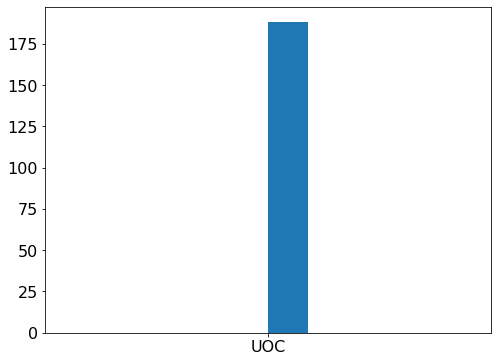

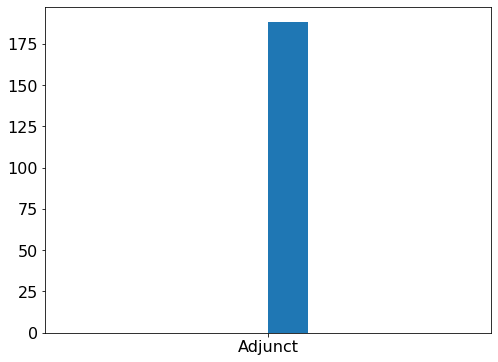

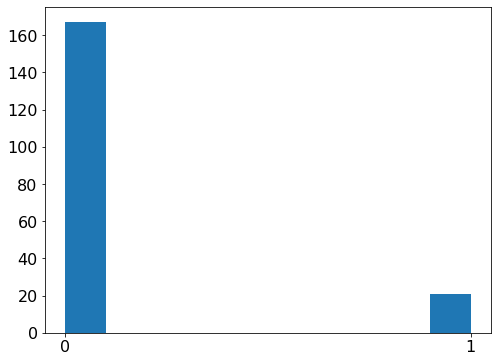

In [23]:
plt.hist(meta.UNIVERSITY)
plt.show()
plt.hist(meta.UOC_POSITION)
plt.show()
plt.hist(meta.USERWIKI)
plt.show()

In [24]:
meta = meta.drop(columns=['UNIVERSITY','UOC_POSITION','USERWIKI'])

In [25]:
meta.apply(lambda x: type(x.values[1]),axis=0)

AGE            <class 'numpy.int64'>
GENDER                 <class 'str'>
DOMAIN                 <class 'str'>
PhD                    <class 'str'>
YEARSEXP               <class 'str'>
OTHERSTATUS            <class 'str'>
dtype: object

## Análisis
Vamos a construir una matriz de distancias de Gower para los datos personales, y realizamos un cluster jerárquico para tener una primera impresión sobre cómo se agrupan los datos.

In [26]:
!pip install gower
import gower

  Created wheel for gower: filename=gower-0.0.5-cp36-none-any.whl size=4232 sha256=cbfc827dc46efb9e3cf06f1afc73ef2232240a4ee61c51e88318101bfedd781f
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


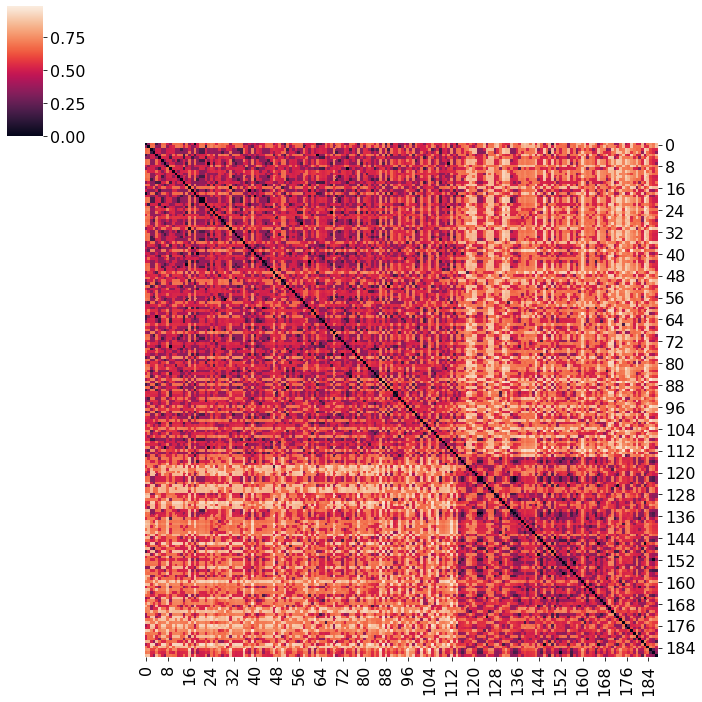

In [28]:
d_meta = gower.gower_matrix(meta)
sns.clustermap(d_meta,row_cluster=False,col_cluster=False)

#### ¿Qué se puede decir de la presencia de grupos en el dataset?

/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


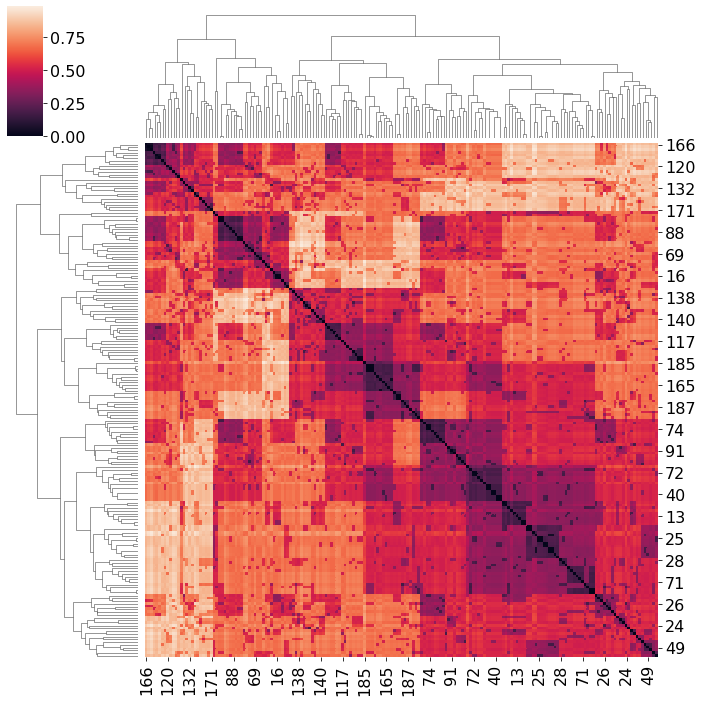

In [29]:
sns.clustermap(d_meta)

#### Jerarquico


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import squareform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


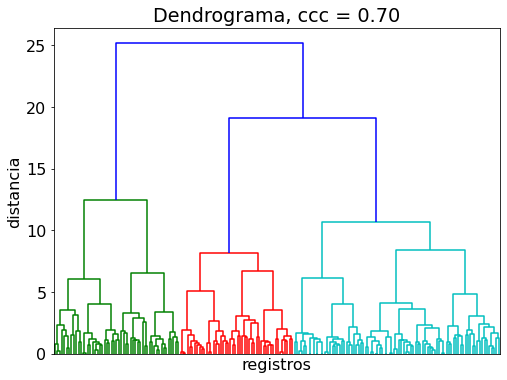

In [31]:
Z = linkage(d_meta, 'ward')
c,_=cophenet(Z,Y=squareform(d_meta))
plt.title('Dendrograma, ccc = %0.2f'%c)
plt.xlabel('registros')
plt.ylabel('distancia')
dn = dendrogram(Z,no_labels=True)

#### PAM
Para agrupar los datos datos vamos a usar el método PAM, y como desconocemos el mejor valor de K a utilizar, vamos a probar varios y después usar los gráficos de SSE vs. k y Silhouette vs. k.
En el loop de más abajo se recorren los valores de k desde 2 hasta el máximo número de k (cantidad de clusters) que se van a probar. En cada iteración se calcula un nuevo PAM y con sus medoides se calcula el SSE y Silhouette.

In [32]:
!pip install scikit-learn-extra 
from sklearn_extra.cluster import KMedoids 
from sklearn.metrics import silhouette_samples, silhouette_score

     |████████████████████████████████| 624kB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340335 sha256=acb2d1d5caa56f075745e6101dee07f32c5bfc548565f62e34d994bb6737c6a5
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [33]:
def calcula_sse_kmedoids(KM,d):
  se = []
  for i in range(0,KM.n_clusters):
    se.append(sum(d[KM.medoid_indices_[i],KM.labels_==i]**2))
  return sum(se)

In [34]:
KM_meta=KMedoids(n_clusters=4,metric='precomputed',init='k-medoids++').fit(d_meta)

In [35]:
print(KM_meta.labels_)
print(KM_meta.medoid_indices_)

[2 2 3 3 2 2 0 0 0 1 0 0 0 0 2 0 2 3 2 3 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2
 2 3 2 3 1 2 3 0 0 0 2 1 0 2 2 0 2 0 0 0 0 2 2 3 1 0 2 2 2 0 3 0 2 0 0 3 2
 1 0 0 3 2 0 1 0 0 0 1 0 2 0 2 0 2 1 1 2 2 0 2 0 2 0 3 2 2 1 2 0 2 2 3 0 0
 0 2 0 2 1 3 3 2 2 2 2 3 3 3 2 2 2 3 3 1 1 1 1 3 3 3 1 3 1 3 1 1 2 3 3 1 3
 3 2 3 1 3 1 3 2 3 1 3 3 1 1 1 1 3 3 2 1 1 3 3 2 1 1 1 1 2 2 1 1 1 1 3 1 2
 3 3 0]
[  7 137   0 122]


In [36]:
print(silhouette_score(d_meta,KM_meta.labels_,metric='precomputed'))
print(calcula_sse_kmedoids(KM_meta,d_meta))
silhouette_samples(d_meta,KM_meta.labels_,metric='precomputed')

0.1349518
26.629265038185622


array([ 3.49514246e-01,  2.88187563e-01, -1.48441792e-01, -1.41605526e-01,
        3.42238992e-01,  3.74797732e-02,  2.18577400e-01,  2.97423750e-01,
        9.50172395e-02,  4.49480079e-02,  2.01406360e-01,  2.11776823e-01,
        2.25839838e-01,  1.60478473e-01, -1.75985377e-02,  2.39173353e-01,
        2.31877655e-01,  1.40251732e-02,  3.59596550e-01,  1.99178532e-02,
        1.67112008e-01,  1.66019619e-01, -9.93536264e-02,  2.97423750e-01,
        1.43085152e-01,  2.50707626e-01,  1.28504306e-01,  1.44221172e-01,
        1.88386604e-01,  2.81232566e-01,  1.77436188e-01,  2.36459240e-01,
        1.92258641e-01,  2.86826879e-01,  2.04590261e-01,  1.18240312e-01,
        1.91372499e-01,  2.39383802e-03,  1.40251732e-02,  2.30071679e-01,
        1.99178532e-02,  3.36569399e-02, -1.63670257e-01,  2.73834895e-02,
        2.44676307e-01,  2.34263003e-01,  2.95750588e-01,  2.39041969e-01,
       -4.47419025e-02,  2.85340637e-01,  2.23188892e-01,  2.97887146e-01,
        1.93057895e-01, -

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster 

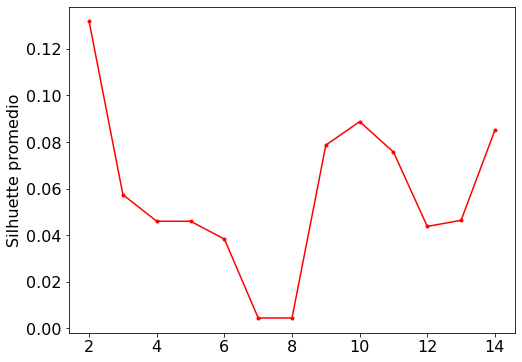

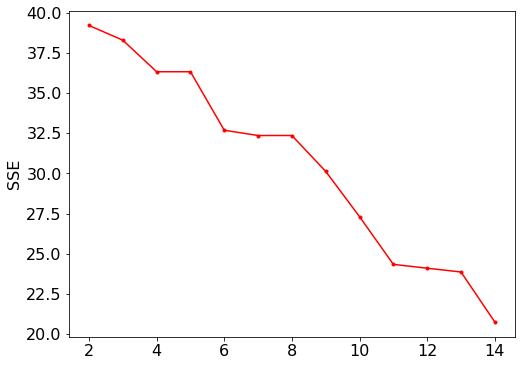

In [37]:
range_k = [i for i in range(2,15)]
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='heuristic').fit(d_meta)

    silh.append(silhouette_score(d_meta,KM_meta.labels_,metric='precomputed'))
    sse.append(calcula_sse_kmedoids(KM_meta,d_meta))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()


#### ¿Cómo se interpretan estos gráficos?
#### ¿Por qué el valor de Silhouette sube, baja a partir de k > 4 y después vuelve a subir gradualmente? 
Ayuda: mirar el cluster jerárquico que hicimos antes.

Probamos primero con k=10.

In [39]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='precomputed')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='precomputed')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  "its corresponding cluster ({k}).".format(k=k)
/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  "its corresponding cluster ({k}).".format(k=k)


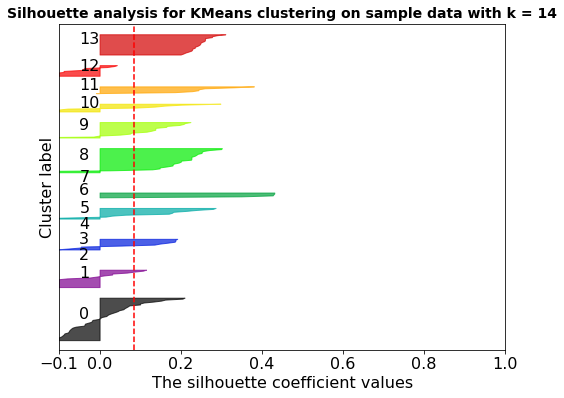

In [40]:
k = 14
KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='heuristic').fit(d_meta)
grafica_silhouette(KM_meta,d_meta)

([<matplotlib.axis.XTick at 0x7f24d7b94160>,
 <a list of 14 Text major ticklabel objects>)

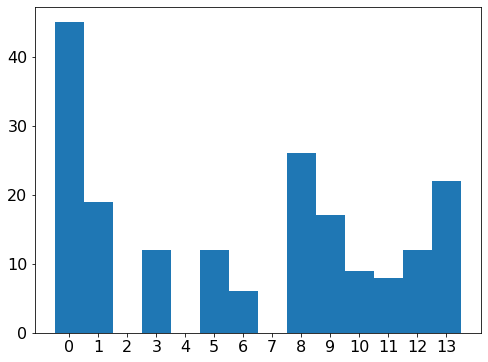

In [41]:
plt.hist(KM_meta.labels_,bins=14,range=[-0.5,13.5])
plt.xticks(np.arange(0,14))

Veamos los valores que toman los prototipos

In [42]:
meta.iloc[KM_meta.medoid_indices_]

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,OTHERSTATUS
504,46,M,Political_Sciences,Y,20,2
200,41,M,Political_Sciences,Y,15,2
268,41,M,Political_Sciences,Y,15,2
211,42,M,Political_Sciences,Y,18,2
274,42,M,Political_Sciences,Y,18,2
407,38,M,Political_Sciences,Y,12,2
286,42,M,Political_Sciences,Y,14,2
335,42,M,Political_Sciences,Y,14,2
348,43,M,Political_Sciences,N,20,7
605,34,F,Political_Sciences,Y,10,7


Para este ejercicio nos quedamos con k=4, que no es necesariamente el mejor valor.

/usr/local/lib/python3.6/dist-packages/sklearn_extra/cluster/_k_medoids.py:235: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  "its corresponding cluster ({k}).".format(k=k)


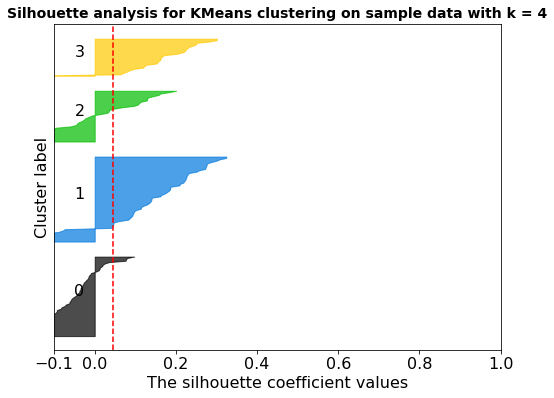

In [43]:
k = 4
KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='heuristic').fit(d_meta)
grafica_silhouette(KM_meta,d_meta)

In [44]:
meta.iloc[KM_meta.medoid_indices_]

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,OTHERSTATUS
504,46,M,Political_Sciences,Y,20,2
166,41,M,Political_Sciences,Y,15,7
382,34,M,Political_Sciences,Y,12,2
211,42,M,Political_Sciences,Y,18,2


# Encuestas

## Análisis de las respuestas a las encuestas
Primero realicemos un cluster con el método PAM usando las distancias Euclideas entre respuestas.

In [45]:
encu.head()

,PU1,PU2,PU3,PEU1,PEU2,ENJ1,ENJ2,Qu1,Qu2,Qu3,Qu4,Qu5,Vis1,Vis3,Im1,Im2,Im3,SA1,SA2,SA3,Use1,Use2,Use3,Use4,Use5,Pf1,Pf2,Pf3,JR1,JR2,BI1,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
148,5,5,5,5,4,5,4,4,4,4,4,4,5,4,4,5,5,4,5,5,3,4,5,5,4,3,3,4,5,3,4,4,4,4,4,4,4,5,5,2,4
149,3,2,2,4,4,2,3,3,3,3,3,2,2,2,2,4,2,4,4,3,1,1,2,2,3,1,1,2,2,2,2,3,4,4,3,4,2,3,4,1,2
160,2,2,1,4,3,2,3,2,2,2,4,1,2,1,1,3,1,3,4,3,1,1,1,1,2,2,2,2,3,2,1,1,1,1,1,1,1,2,3,1,1
164,3,4,4,4,4,5,4,4,3,3,3,3,3,1,2,2,2,3,2,3,1,1,3,2,4,1,1,1,3,3,3,3,3,5,3,3,2,3,1,1,1
165,4,4,3,5,5,4,4,3,4,2,3,3,2,1,3,4,5,5,5,5,1,1,3,3,4,2,3,3,5,4,3,3,4,4,5,3,4,4,4,2,3


In [46]:
KM_encu_eucl = KMedoids(n_clusters=5,metric='euclidean',init='heuristic').fit(encu)
KM_encu_eucl.labels_

array([3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 4, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1,
       2, 3, 3, 3, 4, 1, 1, 2, 2, 1, 3, 0, 1, 0, 3, 4, 3, 3, 2, 0, 4, 3,
       4, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 1, 0, 3,
       1, 3, 3, 0, 3, 3, 0, 1, 0, 4, 1, 1, 3, 4, 3, 3, 4, 3, 0, 1, 1, 1,
       4, 4, 3, 1, 0, 3, 0, 3, 1, 2, 1, 3, 1, 0, 1, 3, 3, 0, 0, 1, 1, 1,
       1, 3, 1, 1, 3, 0, 1, 3, 0, 4, 3, 1, 1, 3, 1, 0, 3, 3, 0, 1, 4, 1,
       3, 1, 1, 2, 1, 4, 3, 0, 1, 3, 1, 2, 2, 1, 1, 1, 0, 4, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3,
       3, 0, 2, 1, 3, 0, 0, 0, 1, 3, 1, 3])

In [47]:
from sklearn.metrics import pairwise_distances
d_encu_eucl = pairwise_distances(encu, metric='euclidean')
print(calcula_sse_kmedoids(KM_encu_eucl,d_encu_eucl))
print(silhouette_score(encu,KM_encu_eucl.labels_,metric='euclidean'))

8250.0
0.02825456280752423


### Una función de distancia para variables categóricas ordenadas.
Las respuestas están codificadas con cinco valores enteros ordenados. En consecuencia, en lugar de la distancia euclídea, podríamos usar alguna de distancia para variables categóricas ordenadas, como la que vimos en la térocia de medidas de (di)similitud. Para normalizar las distancias entre 0 y 1, vamos a tener en cuenta que el máximo valor de disimilitud es la máxima diferencia entre respuestas, 5-1 = 4. Por ejemplo, para la distancia entre dos encuestados cualquiera:

In [48]:
nobs = encu.shape[0]
np_encu = encu.to_numpy().astype(float)
norm = encu.shape[1]*( np.amax(np_encu) - 1 ) # numero de columnas * max de disimilitud
d_encu_cat = np.full([nobs,nobs],np.nan)
for i in range(0,nobs):
  for j in range(0,nobs):
    d_encu_cat[i,j] = sum(abs(np_encu[i,:]-np_encu[j,:]))/norm

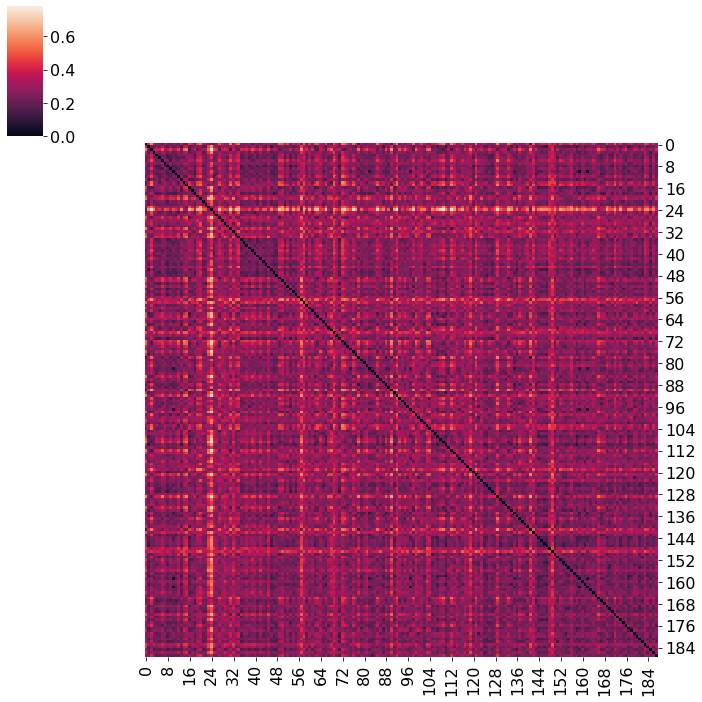

In [49]:
sns.clustermap(d_encu_cat,row_cluster=False,col_cluster=False)

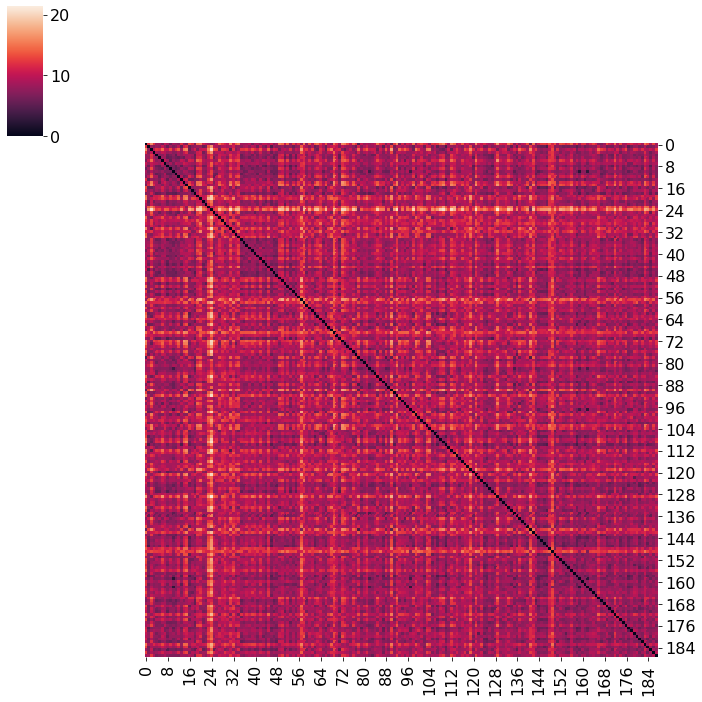

In [50]:
sns.clustermap(d_encu_eucl,row_cluster=False,col_cluster=False)

In [51]:
KM_encu_cat = KMedoids(n_clusters=2,metric='precomputed',init='heuristic').fit(d_encu_cat)
print(calcula_sse_kmedoids(KM_encu_cat,d_encu_cat))
print(silhouette_score(d_encu_cat,KM_encu_cat.labels_,metric='precomputed'))

7.651360797144556
0.20408559033118973


In [52]:
tmp = pd.DataFrame({'Meta': KM_meta.labels_, 'Encu': KM_encu_cat.labels_})# Create a DataFrame with labels and varieties as columns: df
ct = pd.crosstab(tmp['Meta'], tmp['Encu']) # Create crosstab: ct
ct

Encu,0,1
Meta,,
0,33,26
1,30,33
2,23,15
3,14,14


In [53]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [54]:
print(vanDongen(ct))

0.971830985915493


In [55]:
from sklearn.metrics import adjusted_rand_score
print(adjusted_rand_score(KM_meta.labels_, KM_encu_cat.labels_))

-0.0030807736329548224
